# Using the Emulator with Prospector

In [1]:
import numpy as np

from prospect.fitting import fit_model
from prospect.io.write_results import write_hdf5
from prospect.plotting.utils import sample_posterior

import corner

# Load code from this repository
from parrotpy.utils import *
from parrotpy.obs import *
from parrotpy.models import *
from parrotpy.sps import *

In [2]:
parnames = [
    "logmass",
    "logzsol",
    "logsfr_ratio_1",
    "logsfr_ratio_1",
    "logsfr_ratio_1",
    "logsfr_ratio_1",
    "logsfr_ratio_1",
    "logsfr_ratio_1",
    "dust2",
    "dust_index",
    "dust1_fraction",
    "log_fagn",
    "log_agn_tau",
    "gas_logz",
    "duste_qpah",
    "duste_umin",
    "log_duste_gamma",
]

## Fitting with Emulator

The first thing we need to do is set up the configuration settings, which get passed to the various `build_obs`, `build_sps`, `build_model`, and `fit_model` functions. The settings listed below will work for both the emulator and FSPS fits below. If you'd like to try fitting different mock objects, feel free to change `objid` (you can select any value between `1` and `10_000`).

In [3]:
run_params = {
    # object selection
    'objid': 1,
    # emulator selection
    'emulfp': os.path.join(os.getcwd(), '..', 'data', 'parrot_v4_obsphot_256n_5l_05z30.npy'),
    # dynesty params
    'nested_maxbatch': None, # maximum number of dynamic patches
    'nested_bound': 'multi', # bounding method
    'nested_sample': 'rwalk', # sampling method
    'nested_walks': 50, # MC walks
    'nested_nlive_batch': 200, # size of live point "batches"
    'nested_nlive_init': 100, # number of initial live points
    'nested_weight_kwargs': {'pfrac': 1.0}, # weight posterior over evidence by 100%
    'nested_target_n_effective': 2000, # target effective sample size
    'nested_dlogz_init': 0.02,
    # FSPS info
    'zcontinuous': 2,
    'compute_vega_mags': False,
    'initial_disp':0.1,
    'interp_type': 'logarithmic',
    'nbins_sfh': 7,
    'df': 2,
    'agelims': [0.0,7.4772,8.0,8.5,9.0,9.5,9.8,10.0],
}

One thing to note here is that the `dynesty` settings listed above are far less stringent than those used in the paper. In the paper, we used `nested_nlive_init = 1000` and `nested_target_n_effective = 200000`. Downgrading the settings in the notebook here is just to speed up the fits by calling the emulator/FSPS fewer times - in real-world use, you'll want to use more stringent settings!

Now we can load the mock observation:

In [4]:
obs = build_obs(**run_params)
obs.keys()

dict_keys(['filters', 'wave_effective', 'phot_mask', 'maggies', 'maggies_unc', 'wavelength', 'spectrum', 'logify_spectrum', 'zred', 'truth'])

Next we can load the SPS object.

In [5]:
sps_emul = build_sps_emulator(**run_params)

Somewhat counterintuitively, we actually don't need this to be set to anything when using the emulator (all of the emulation stuff takes place in the model object). Hence:

Speaking of the model object:

In [6]:
model_emul = build_model_emulator(obs=obs, sps=sps_emul, **run_params)
to_hold = ['dust_index', 'gas_logz','log_agn_tau', 'duste_qpah', 'duste_umin', 'log_duste_gamma']
for param in to_hold:
    model_emul.config_dict[param]['isfree'] = False

One thing we need to do when fitting with the emulator is taking the emulator's uncertainties in each filter into account - to do this, we'll use the `modify_obs` function provided by this repo.

In [9]:
model_emul

:::::::
<class 'parrotpy.models.JAXGELUEmulator'>

Free Parameters: (name: prior) 
-----------
  massmet: <class 'parrotpy.models.FastMassMet'>()
  logsfr_ratios: <class 'parrotpy.models.FastTruncatedEvenStudentTFreeDeg2'>()
  dust1_fraction: <class 'parrotpy.models.FastTruncatedNormal'>()
  dust2: <class 'parrotpy.models.FastTruncatedNormal'>()
  log_fagn: <class 'parrotpy.models.FastUniform'>()

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [0.99842992] 
  logmass: [10.] <function massmet_to_logmass at 0x2e6291b40>
  logzsol: [-0.5] <function massmet_to_logzsol at 0x2eb8c95a0>
  dust_index: [0.7] 
  gas_logz: [-0.5] 
  log_agn_tau: [1.30103] 
  duste_qpah: [2.] 
  duste_umin: [1.] 
  log_duste_gamma: [-2.] 
  peraa: [False] 
  mass_units: ['mformed'] 

In [8]:
obs_emul = modify_obs(obs=obs, model=model_emul)

With all that out of the way, we can now fit the mock object with the emulator. With the `dynesty` settings chosen above, this shouldn't take too long (~1 minute).

In [10]:
output_emul = fit_model(obs_emul, model_emul, sps_emul, **run_params)

iter: 2522 | batch: 0 | nc: 1 | ncall: 107388 | eff(%):  2.348 | logz: 1274.427 +/-  0.404 | dlogz:  0.000 >  0.020          20    


done dynesty (initial) in 268.9166569709778s


iter: 4663 | batch: 4 | nc: 1 | ncall: 175238 | eff(%):  2.215 | loglstar: 1288.266 < 1293.790 < 1288.691 | logz: 1274.537 +/-  0.297 | stop:  1.076     

done dynesty (dynamic) in 239.1005380153656s


Now let's take a look at the posterior. First we'll need to resample using the sample weights.

In [11]:
resampled_emul = sample_posterior(
    output_emul["sampling"][0]["samples"],
    weights = np.exp(output_emul["sampling"][0]["logwt"]-output_emul["sampling"][0]["logz"][-1]),
    nsample = 10_000,
)

In [12]:
resampled_emul.shape

(10000, 17)

Then we can create a corner plot:

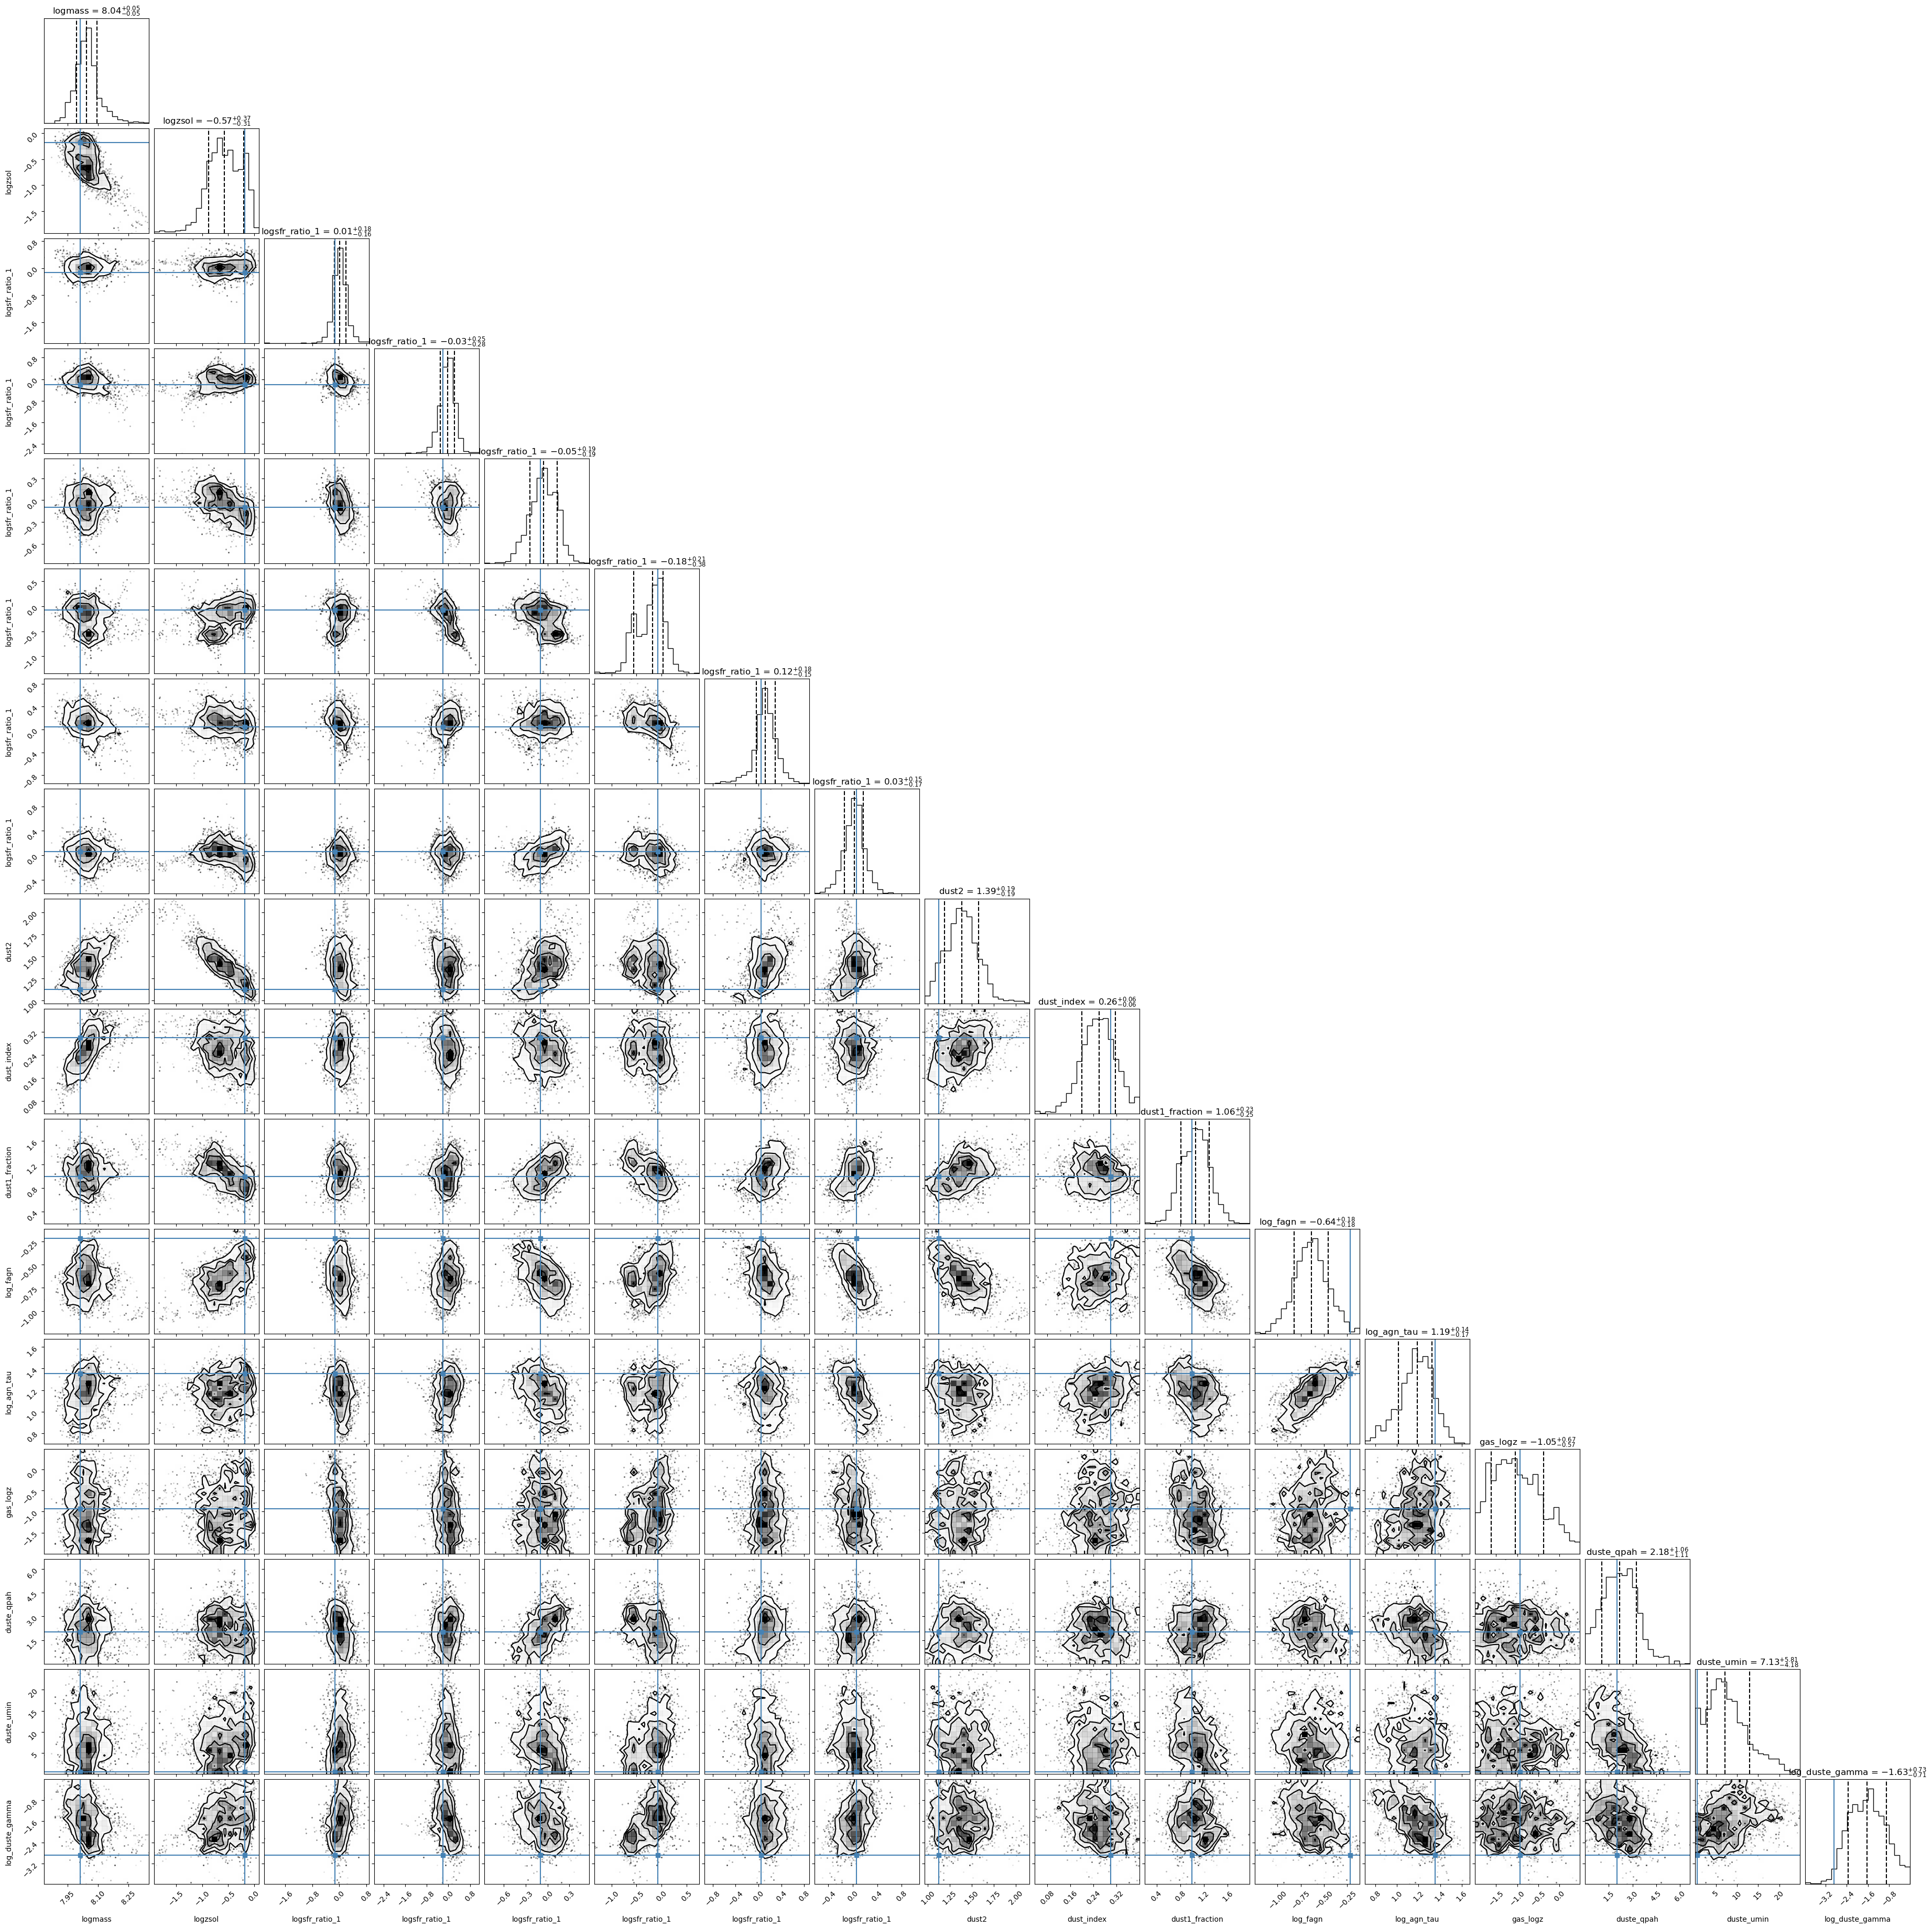

In [13]:
plt_emul = corner.corner(
    resampled_emul,
    labels = parnames,
    quantiles = [0.16, 0.5, 0.84],
    show_titles = True,
    truths = obs["truth"],
)

## Fitting with FSPS

In [ ]:
sps_fsps = build_sps_fsps(**run_params)

In [ ]:
model_fsps = build_model_fsps(obs=obs, sps=sps_fsps, **run_params)

Now we can actually run the fit using FSPS. This will take *much* longer (~6 hours).

*Note:* The following cell will produce many `RuntimeWarning` messages. These are caused by Prospector's `smoothspec` function and can be safely ignored in this case.

In [ ]:
output_fsps = fit_model(obs, model_fsps, sps_fsps, **run_params)

## Fitting with Stitched Emulator

As described in Section 4.3 of the paper, we've proposed a method for emulating difficult parameters where one produces multiple emulators trained over different, sligthly overlapping ranges in that parameter, and then allow the two overlapping emulators to "vote" on the photometry prediction in a differentiable way.

In this repository, we provide an example of this sort of emulator - in this case, a composite emulator composed of 24 individual emulators that collectively cover redshift for $0 < z < 24$. This is stored in the `parrot_v4_obsphot_512n_5l_24s_00z24.npy` file in the `/data` directory.

To load this, we'll slightly alter the `run_params` dictionary.

In [21]:
run_params["emulfp"] = os.path.join(
    os.getcwd(),
    '..',
    'data',
    'parrot_v4_obsphot_512n_5l_24s_00z24.npy',
)

Then we can load the model using the `build_model_stitched` function.

In [22]:
model_stitched = build_model_stitched(obs=obs, sps=sps_emul, **run_params)

Note that this example model allows redshift to be fit as a free variable - note that `zred` is listed as a free variable below:

In [23]:
model_stitched

:::::::
<class 'models.PhotoMultiEmulator'>

Free Parameters: (name: prior) 
-----------
  zred: <class 'models.FastUniform'>()
  massmet: <class 'models.FastMassMet'>()
  logsfr_ratios: <class 'models.FastTruncatedEvenStudentTFreeDeg2'>()
  dust1_fraction: <class 'models.FastTruncatedNormal'>()
  dust2: <class 'models.FastTruncatedNormal'>()
  dust_index: <class 'models.FastUniform'>()
  gas_logz: <class 'models.FastUniform'>()
  log_fagn: <class 'models.FastUniform'>()
  log_agn_tau: <class 'models.FastUniform'>()
  duste_qpah: <class 'models.FastTruncatedNormal'>()
  duste_umin: <class 'models.FastTruncatedNormal'>()
  log_duste_gamma: <class 'models.FastTruncatedNormal'>()

Fixed Parameters: (name: value [, depends_on]) 
-----------
  logmass: [10.] <function massmet_to_logmass at 0x2d4da9c60>
  logzsol: [-0.5] <function massmet_to_logzsol at 0x2da39d120>
  peraa: [False] 
  mass_units: ['mformed'] 

Like before, we'll need to modify the `obs` dictionary to account for the uncertainty the emulator will add to the fit. This can be done with the `modify_obs_stitched` function here:

In [24]:
obs_stitched = modify_obs_stitched(obs=obs, model=model_stitched)

Now we can run the fit!

In [ ]:
output_stitched = fit_model(obs_stitched, model_stitched, sps_emul, **run_params)